# Where are we: Have we seen a DFG flip?

There are a few things to look at here. Mostly we are interested in making sure we are actually analyzing meaningful things in our kinase simulations so that we can drive a transition along that coordinate. The main things to investigate along these lines are:
 - Is the DFG dihedral we are using misleading?
 - How informative are the dihedrals Josh found in analyzing ensembler started models?  https://github.com/maxentile/MSMs/blob/master/results/Discriminating_runs.ipynb
 - Are the reaction coordinates of this paper useful to look at? http://www.ncbi.nlm.nih.gov/pubmed/25839999
 - Can we use this ipynb embbeded structure viewer to useful confirm our analysis: https://github.com/arose/nglview
 - Are the KER salt bridge distances actually useful distances in this context?
 - I also want to use snippets from David's new notebook to help investigate these things: https://github.com/choderalab/octomore/blob/master/11400-run24.ipynb


## Section 1: The current DFG dihedral and Src sims (project 11401)

Here we are just going load in already saved dihedrals for separated runs.
Also note this needs to be run on the cluster. Checkout this discussion for how to get ipython notebooks to work on the cluster: https://github.com/cBio/cbio-cluster/issues/334#issuecomment-151602300

Also note I've just dumped all the code here, though I'm also in the process of cleaning it up and migrating it
to the 'kinalysis' repository.

In [1]:
import matplotlib

import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from msmbuilder import dataset

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

# load clone0 of each trajectory

Abl_trajectories_0 = dataset.MDTrajDataset("/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/11400/*clone0.h5")
Src_trajectories_0 = dataset.MDTrajDataset("/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/11401/*clone0.h5")


In [3]:
# define DFG dihedral (this is from Roux umbrella sampling paper and are AlaCbeta, AlaCalpha, AspCalpha, AspCgamma)

Abl_DFG = [2257,2255,2265,2270]
Src_DFG = [2190,2188,2198,2203]

Abl_runs = len(Abl_trajectories_0)
Src_runs = len(Src_trajectories_0)

Abl_project = 11400
Src_project = 11401

In [4]:
def DFG_dihedral(trajectories,def_DFG):

    dihedral = []

    for traj in trajectories:

        dihedral.append(md.compute_dihedrals(traj,[def_DFG]))

    flattened_dihedral = np.asarray([val for sublist in dihedral for val in sublist])

    return [flattened_dihedral]

def DFG_dihedral_byrun(project,runs,def_DFG):
    
    dihedral = []
    dihedral_combinetrajs = []
    print "Working on project %s." % project

    for run in range(runs):
     
        trajectories = dataset.MDTrajDataset("/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/%d/run%d-clone*.h5" % (project,run))
        print "Run %s has %s trajectories." % (run,len(trajectories))        

        for traj in trajectories:

            dihedral_combinetrajs.append(md.compute_dihedrals(traj,[def_DFG]))
        # flatten
        dihedral_combinetrajs = [val for sublist in dihedral_combinetrajs for val in sublist]

        dihedral.append(dihedral_combinetrajs) 
        dihedral_combinetrajs = []

    dihedral = np.asarray([dihedral])

    return [dihedral]

#[Abl_dihedral] = DFG_dihedral_byrun(Abl_project, Abl_runs, Abl_DFG)
#[Src_dihedral] = DFG_dihedral_byrun(Src_project, Src_runs, Src_DFG)

#np.save('Abl_dihedral_newsims_separate_mwt.npy',Abl_dihedral)
#np.save('Src_dihedral_newsims_separate_mwt.npy',Src_dihedral)

Abl_dihedral = np.load('Abl_dihedral_newsims_separate_mwt.npy')
Src_dihedral = np.load('Src_dihedral_newsims_separate_mwt.npy')

# Calculate dihedral at the first frame of clone0 of each run

Abl_firstframes = [traj[0] for traj in Abl_trajectories_0]
Src_firstframes = [traj[0] for traj in Src_trajectories_0]

[Abl_lines] = DFG_dihedral(Abl_firstframes, Abl_DFG)
[Src_lines] = DFG_dihedral(Src_firstframes, Src_DFG)




In [5]:
# Rotate dihedral so histogram doesn't get cut in figure
import math

Abl_rotate = [ np.array( [A-(2*math.pi) if A >= 1.9 else A for A in run ] ) for run in Abl_dihedral[0] ]
Src_rotate = [ np.array( [S-(2*math.pi) if S >= 1.9 else S for S in run ] ) for run in Src_dihedral[0] ]

Abl_line_rotate =  [A-(2*math.pi) if A >= 1.9 else A for A in Abl_lines]
Src_line_rotate =  [S-(2*math.pi) if S >= 1.9 else S for S in Src_lines]

# Define which sims start in DFG-in vs DFG-out conformation
Abl_line_rotate = np.asarray(Abl_line_rotate)
Src_line_rotate = np.asarray(Src_line_rotate)

Abl_DFG_in = np.where(Abl_line_rotate > -0.5)
Abl_DFG_out = np.where(Abl_line_rotate < -0.5)

Src_DFG_in = np.where(Src_line_rotate > -0.5)
Src_DFG_out = np.where(Src_line_rotate < -0.5)

# Accumulate these in a loop.
abl_in = np.vstack([ Abl_rotate[index] for index in Abl_DFG_in[0]])
src_in = np.vstack([ Src_rotate[index] for index in Src_DFG_in[0]])
abl_out = np.vstack([ Abl_rotate[index] for index in Abl_DFG_out[0]])
src_out = np.vstack([ Src_rotate[index] for index in Src_DFG_out[0]])



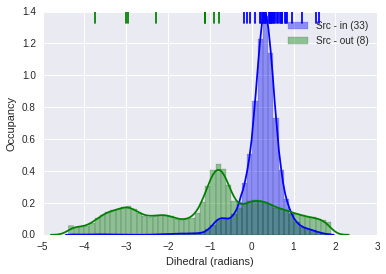

In [6]:
# Plot vertical lines at dihedral for first frames
#for i in range(len(Abl_line_rotate)):
#        plt.axvline(Abl_line_rotate[i], color="r")
#for i in range(len(Src_line_rotate)):
#        plt.axvline(Src_line_rotate[i], color="b")
#plt.vline can set y range.

#Plot just vertical lines for Src DFG out

Src_line_rotate_out = np.vstack([ Src_line_rotate[index] for index in Src_DFG_out[0]])
Src_line_rotate_in = np.vstack([ Src_line_rotate[index] for index in Src_DFG_in[0]])

for i in range(len(Src_line_rotate_in)):
        plt.axvline(Src_line_rotate_in[i], color="b", ymin=0.95)
for i in range(len(Src_line_rotate_out)):
        plt.axvline(Src_line_rotate_out[i], color="g", ymin=0.95)

# Plot histogram with special seaborn sauce
#sns.distplot(abl_in, color="r",label="Abl - in (%s) " %len(Abl_DFG_in[0]) )
#sns.distplot(abl_out, color="m",label="Abl - out (%s) " %len(Abl_DFG_out[0]) )
sns.distplot(src_in, color="b",label="Src - in (%s) " %len(Src_DFG_in[0]) )
sns.distplot(src_out, color="g",label="Src - out (%s)" %len(Src_DFG_out[0]) )

plt.xlabel('Dihedral (radians)')
plt.ylabel('Occupancy')
plt.legend()

So this makes it look like we are seeing the DFG flip! Let's look a little closer, at individual trajectories starting from the DFG-out conformation.

In [7]:
Src_dihedral = np.load('Src_dihedral_newsims_separate_mwt.npy')

(array([ 5,  8, 19, 25, 29, 30, 31, 39]), array([0, 0, 0, 0, 0, 0, 0, 0]))


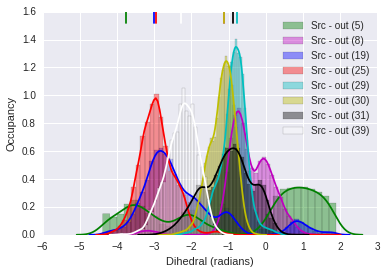

In [8]:
# Rotate dihedral so histogram doesn't get cut in figure
import math

#Note Src_dihedral was imported
Src_rotate = [ np.array( [S-(2*math.pi) if S >= 1.9 else S for S in run ] ) for run in Src_dihedral[0] ]

#While Src_lines assumes you've already run some of the code above
Src_line_rotate =  [S-(2*math.pi) if S >= 1.9 else S for S in Src_lines]

# Define which sims start in DFG-in vs DFG-out conformation
Src_line_rotate = np.asarray(Src_line_rotate)

Src_DFG_in = np.where(Src_line_rotate > -0.5)
Src_DFG_out = np.where(Src_line_rotate < -0.5)

print Src_DFG_out

# Define 8 src_out runs.
#src_out = np.vstack([ Src_rotate[index] for index in Src_DFG_out[0]])
src_out_0 = np.vstack([ Src_rotate[Src_DFG_out[0][0]] ])
src_out_1 = np.vstack([ Src_rotate[Src_DFG_out[0][1]] ])
src_out_2 = np.vstack([ Src_rotate[Src_DFG_out[0][2]] ])
src_out_3 = np.vstack([ Src_rotate[Src_DFG_out[0][3]] ])
src_out_4 = np.vstack([ Src_rotate[Src_DFG_out[0][4]] ])
src_out_5 = np.vstack([ Src_rotate[Src_DFG_out[0][5]] ])
src_out_6 = np.vstack([ Src_rotate[Src_DFG_out[0][6]] ])
src_out_7 = np.vstack([ Src_rotate[Src_DFG_out[0][7]] ])

#Plot just vertical lines for Src DFG out

Src_line_rotate_out = np.vstack([ Src_line_rotate[index] for index in Src_DFG_out[0]])

plt.axvline(Src_line_rotate_out[0], color="g", ymin=0.95)
plt.axvline(Src_line_rotate_out[1], color="m", ymin=0.95)
plt.axvline(Src_line_rotate_out[2], color="b", ymin=0.95)
plt.axvline(Src_line_rotate_out[3], color="r", ymin=0.95)
plt.axvline(Src_line_rotate_out[4], color="c", ymin=0.95)
plt.axvline(Src_line_rotate_out[5], color="y", ymin=0.95)
plt.axvline(Src_line_rotate_out[6], color="k", ymin=0.95)
plt.axvline(Src_line_rotate_out[7], color="w", ymin=0.95)

# Plot histogram with special seaborn sauce
sns.distplot(src_out_0, color="g",label="Src - out (%s)" %Src_DFG_out[0][0] )
sns.distplot(src_out_1, color="m",label="Src - out (%s)" %Src_DFG_out[0][1] )
sns.distplot(src_out_2, color="b",label="Src - out (%s)" %Src_DFG_out[0][2] )
sns.distplot(src_out_3, color="r",label="Src - out (%s)" %Src_DFG_out[0][3] )
sns.distplot(src_out_4, color="c",label="Src - out (%s)" %Src_DFG_out[0][4] )
sns.distplot(src_out_5, color="y",label="Src - out (%s)" %Src_DFG_out[0][5] )
sns.distplot(src_out_6, color="k",label="Src - out (%s)" %Src_DFG_out[0][6] )
sns.distplot(src_out_7, color="w",label="Src - out (%s)" %Src_DFG_out[0][7] )

plt.xlabel('Dihedral (radians)')
plt.ylabel('Occupancy')
plt.legend()

So this is a bit rough, sorry about that. But it gives us some insight that maybe runs 5, 19, 25, and 39 are legitimately our runs that have started in DFG-out and that 19 specifically has flipped.

Lets keep this simple for now: (1) let's see if DFGin fills in the runs we don't see in DFG out and (2) I have reason to believe that run 5 is just a bad model and something we don't want to look further into.

In [9]:
print Src_DFG_in

(array([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 26, 27, 28, 32, 33, 34, 35, 36, 37, 38, 40]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [10]:
print Src_DFG_out

(array([ 5,  8, 19, 25, 29, 30, 31, 39]), array([0, 0, 0, 0, 0, 0, 0, 0]))


Looks fine, indeed src has runs 0-39, and that is how they are numbered.

I guess one question is if Src_line_rotate is in the right order?

In [11]:
len(Src_rotate)

41

In [12]:
len(Src_rotate[8])

68719

In [13]:
len(src_out_1)

68719

In [14]:
import nglview

In [15]:
struc = nglview.PdbIdStructure("3pqr") 

In [16]:
#w = nglview.NGLWidget(struc) 

In [17]:
traj = md.load("/cbio/jclab/projects/fah/fah-data/munged2/no-solvent/11401/run5-clone0.h5")

In [18]:
traj[0].save_pdb('test.pdb')

In [19]:
w = nglview.MDTrajTrajectory(traj)

In [20]:
#nglview.NGLWidget(w)

The NGLviewer widget is not working, getting error:
`TraitError: The 'kernel' trait of a Comm instance must be a Kernel, but a value of type 'NoneType' (i.e. None) was specified.`

####What if we plot the dihedral over time instead of the histogram?

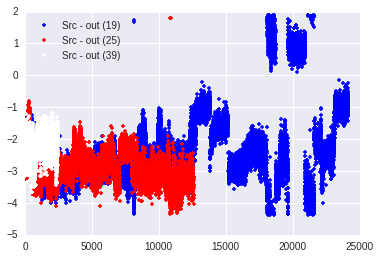

In [27]:
#Let's discard the green guy, and divide these sims out by where they start

#plt.plot(src_out_0, ".g",label="Src - out (%s)" %Src_DFG_out[0][0] )
plt.plot(src_out_2, ".b",label="Src - out (%s)" %Src_DFG_out[0][2] )
plt.plot(src_out_3, ".r",label="Src - out (%s)" %Src_DFG_out[0][3] )
plt.plot(src_out_7, ".w",label="Src - out (%s)" %Src_DFG_out[0][7] )
plt.legend(loc=0);

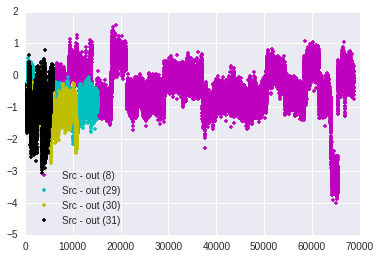

In [25]:
#plt.plot(src_out_0, ".g",label="Src - out (%s)" %Src_DFG_out[0][0] )
plt.plot(src_out_1, ".m",label="Src - out (%s)" %Src_DFG_out[0][1] )
plt.plot(src_out_4, ".c",label="Src - out (%s)" %Src_DFG_out[0][4] )
plt.plot(src_out_5, ".y",label="Src - out (%s)" %Src_DFG_out[0][5] )
plt.plot(src_out_6, ".k",label="Src - out (%s)" %Src_DFG_out[0][6] )
plt.legend(loc=3);

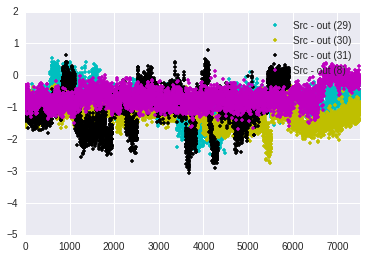

In [23]:
#plt.plot(src_out_0, ".g",label="Src - out (%s)" %Src_DFG_out[0][0] )
plt.plot(src_out_4, ".c",label="Src - out (%s)" %Src_DFG_out[0][4] )
plt.plot(src_out_5, ".y",label="Src - out (%s)" %Src_DFG_out[0][5] )
plt.plot(src_out_6, ".k",label="Src - out (%s)" %Src_DFG_out[0][6] )
plt.plot(src_out_1, ".m",label="Src - out (%s)" %Src_DFG_out[0][1] )
plt.legend();
plt.xlim(0,7500);

From these plots I think runs 8 (magenta) and 19 (blue) are the best to look for this flip.

Let's find some runs that will work well for this.

In [24]:
#OFFLINE SINCE I CAN'T GET NGL VIEWER TO WORK, I CHECKED OUT THESE TRAJECTORIES:
#traj = md.load("/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/11401/run8-clone10.h5")
#traj = md.load("/cbio/jclab/projects/fah/fah-data/munged-with-time/no-solvent/11401/run19-clone19.h5")

These were not as promising as I thought. I'm going to check out the first frame of these trajectories and see if it looks like even this first selection of what starts in a DFG-out vs. a DFG-in confirmation seems reasonable.

First, I'm just going to note that this is why I've discarded run 5 (notice the yellow loop going through the blue loop):

![run5](img/run5_sucks.png "run5 sucks")

Now, I'm comparing these simulations to the SRC structures 1Y57 (DFG-in) and 2OIQ (DFG-out). Checked run0, since it should be representative of DFG-in start, and it looks good:

![run0](img/run0_DFGin.png "Run0 indeed stats in DFGin")

Checking the first frame of runs 8,19,25,29,30,31, and 39, which are supposed to be DFGout. Not looking so good. This seems to be in the DFG-in conformation MORE than the DFG-out conformation. Here is all the DFG residues of these first frames superposed on the 2OIQ DFG-out structure in yellow:

![runs 8,19,25,29,30,31, and 39](img/DFGs.png "runs 8,19,25,29,30,31, and 39")

While looking at this, thought that maybe we should just be looking at something as simple as the RMSD of the phenylalanine to determine DFG-in vs. DFG-out?  Well, I have many other well-established candidates to test first.

## Section 2: Josh's separation of runs